In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np


<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
C:\Users\franco\AppData\Local\Temp\ipykernel_11140\1403581747.py:2: SyntaxWarning: invalid escape sequence '\m'
  image_path = 'archivos\monedas.jpg'


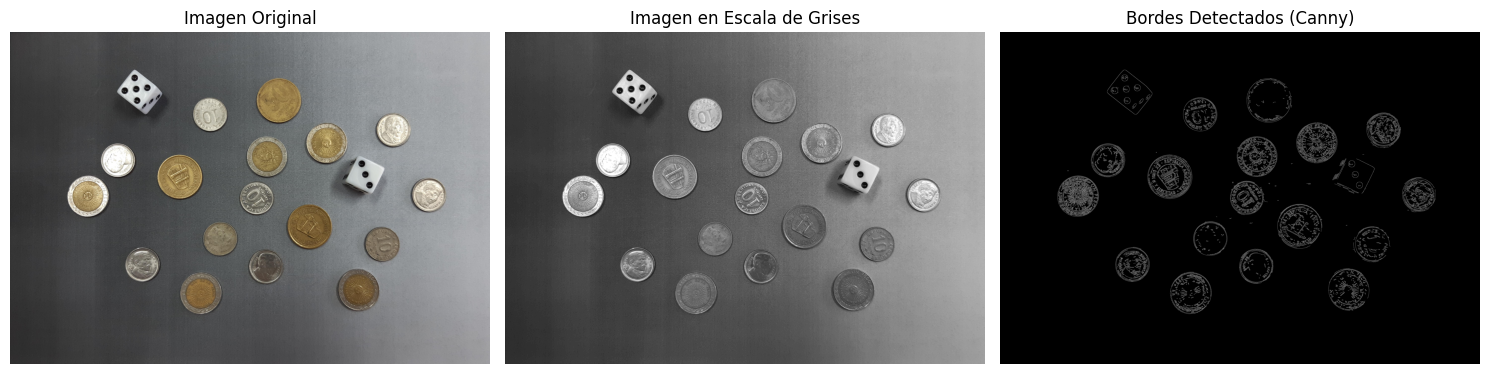

In [18]:
# Cargar la imagen proporcionada
image_path = 'archivos\monedas.jpg'
image = cv2.imread(image_path)

# Convertir la imagen a escala de grises para simplificar el procesamiento
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Aplicar un desenfoque para reducir el ruido y facilitar la segmentación
blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

# Detectar bordes utilizando Canny Edge Detection
edges = cv2.Canny(blurred_image, 50, 150)

# Dilatar los bordes para unir fragmentos cercanos
dilated_edges = cv2.dilate(edges, None, iterations=1)

# Mostrar la imagen original, en escala de grises, y los bordes detectados
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax[0].set_title("Imagen Original")
ax[0].axis("off")

ax[1].imshow(gray_image, cmap='gray')
ax[1].set_title("Imagen en Escala de Grises")
ax[1].axis("off")

ax[2].imshow(edges, cmap='gray')
ax[2].set_title("Bordes Detectados (Canny)")
ax[2].axis("off")

plt.tight_layout()
plt.show()


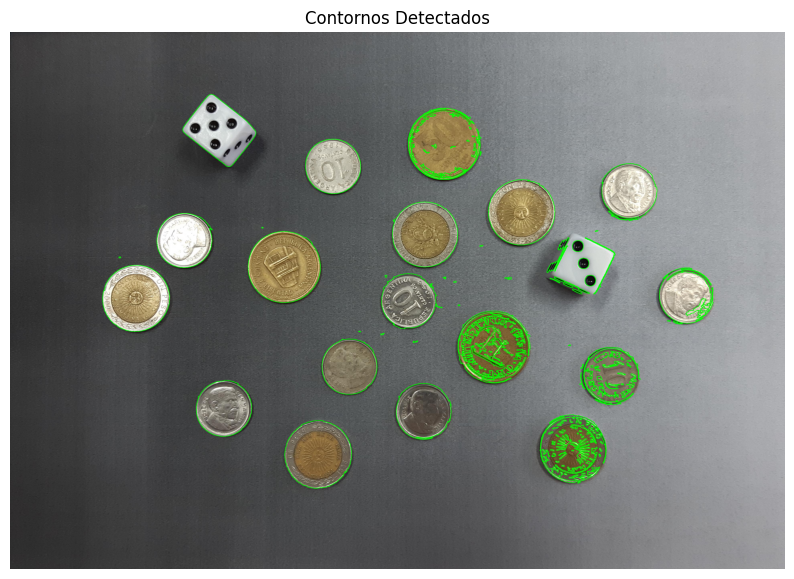

214

In [19]:
# Realizar una segmentación utilizando detección de contornos
# Encontrar los contornos en la imagen de bordes
contours, _ = cv2.findContours(dilated_edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Crear una copia de la imagen original para dibujar los contornos detectados
contour_image = image.copy()

# Dibujar todos los contornos detectados
cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)

# Mostrar la imagen con los contornos dibujados
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
plt.title("Contornos Detectados")
plt.axis("off")
plt.show()

# Número total de objetos detectados
num_objects = len(contours)
num_objects


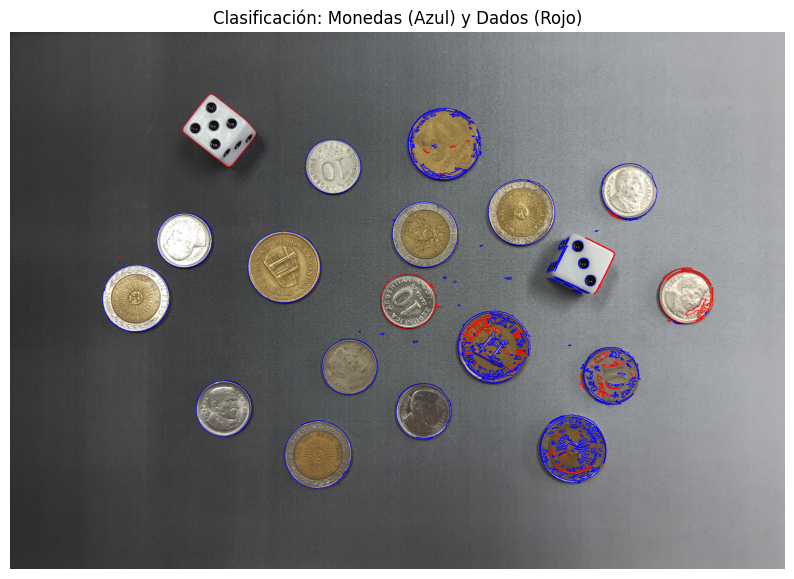

(168, 46)

In [24]:
# Crear listas para almacenar las monedas y dados detectados
monedas = []
dados = []

# Umbral para el factor de forma de los círculos
factor_circulo = 12.57
tolerancia = 1 # Ajuste según precisión deseada

# Iterar a través de los contornos detectados
for contour in contours:
    # Calcular el área y el perímetro del contorno
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    
    # Evitar divisiones por cero
    if perimeter == 0 or area == 0:
        continue
    
    # Calcular el Factor de Forma (Fp)
    Fp = perimeter ** 2 / area
    
    # Clasificar según el Factor de Forma
    if abs(Fp - factor_circulo) < tolerancia:  # Verificar si es un círculo (moneda)
        monedas.append(contour)
    else:
        # Verificar si el contorno es un cuadrado (dado) usando aproximación de polígonos
        approx = cv2.approxPolyDP(contour, 0.04 * perimeter, True)
        if len(approx) == 4:  # Dados tienen 4 lados aproximadamente
            dados.append(contour)
        else:
            # Si no cumple, se clasifica como moneda por descarte
            monedas.append(contour)

# Dibujar los contornos clasificados en la imagen
classification_image = image.copy()
cv2.drawContours(classification_image, monedas, -1, (255, 0, 0), 2)  # Monedas en azul
cv2.drawContours(classification_image, dados, -1, (0, 0, 255), 2)    # Dados en rojo

# Mostrar la imagen con las clasificaciones
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(classification_image, cv2.COLOR_BGR2RGB))
plt.title("Clasificación: Monedas (Azul) y Dados (Rojo)")
plt.axis("off")
plt.show()

# Mostrar el conteo de monedas y dados
num_monedas = len(monedas)
num_dados = len(dados)
num_monedas, num_dados
